In [49]:
import datetime
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# Construct the dataset

In [50]:
def downloadData():

    first_date = (datetime.date(2020, 2, 24))
    last_date = (datetime.date(2022, 8, 4))

    for delta in range(1, (last_date - first_date).days):

        today = first_date + datetime.timedelta(days=delta)
        today_url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+today.strftime("%Y%m%d")+'.csv'
        present = pd.read_csv(today_url)
        present.to_csv('date_datasets/'+today.strftime("%Y%m%d")+'.csv', index=False)

In [51]:
#downloadData()

In [52]:
regioni = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Friuli-Venezia Giulia", "Lazio", "Liguria", "Lombardia", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]
regioni_no_friuli = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Lombardia", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]

first_date = (datetime.date(2020, 9, 1))   # perché all'inizio i dati erano sballati
last_date = (datetime.date(2022, 8, 4))

In [53]:
def dateToRegion(regioni, first_date, last_date):

    for regione in regioni_no_friuli:

        regione_csv = pd.DataFrame(data={"perc_story": [], "ospedalizzati_story": []})

        for delta in range(1, (last_date - first_date).days):
            # open the files
            today = first_date + datetime.timedelta(days=delta)
            yesterday = today - datetime.timedelta(days=1)
            present = pd.read_csv('date_datasets/'+today.strftime("%Y%m%d")+'.csv')
            past = pd.read_csv('date_datasets/'+yesterday.strftime("%Y%m%d")+'.csv')
            regione_present = present[ present['denominazione_regione'] == regione ]
            regione_past = past[ past['denominazione_regione'] == regione ]
            # compute the perc
            try:
                tot_tamponi_present = regione_present['tamponi'].values[0]
            except:
                print(regione)
                print(today)
                print(regione_present['tamponi'])
            tot_tamponi_past = regione_past['tamponi'].values[0]
            tamponi_oggi = tot_tamponi_present - tot_tamponi_past
            nuovi_positivi = regione_present['nuovi_positivi'].values[0]
            percentuale = np.around(nuovi_positivi / tamponi_oggi * 100, 2)     # <---
            # compute the hospitalized
            ospedalizzati_attuali = regione_present['totale_ospedalizzati'].values[0]       # <---
            # append the row
            nuova_riga = pd.DataFrame([[percentuale, ospedalizzati_attuali]],
                                        columns=["perc_story", "ospedalizzati_story"])
            regione_csv = pd.concat([regione_csv, nuova_riga])
        
        regione_csv.to_csv(f"region_datasets/{regione}.csv", index=False)

In [54]:
#dateToRegion(regioni_no_friuli, first_date, last_date)

# Preprocess the datasets

In [55]:
def plot_data(perc, ospedalizzati, cut=300):

    perc_plot = perc[:cut]
    ospedalizzati_plot = ospedalizzati[:cut]

    ospedalizzati_max = ospedalizzati_plot.max()
    perc_max = perc_plot.max()
    perc_plot = perc_plot / perc_max * ospedalizzati_max

    plt.plot(ospedalizzati_plot, color='orange')
    plt.plot(perc_plot, color='red')
    plt.show()

In [56]:
def preprocessDatasets(regions_array, window_length, perc_shift=7, interval=7):

    global_dataset = np.empty([0, window_length//interval, 3])

    for regione in regions_array:

        dataset = pd.read_csv(f"region_datasets/{regione}.csv").replace([np.inf, -np.inf], np.nan).interpolate()

        # mean and shift the perc
        perc = dataset['perc_story']
        perc = perc.rolling(window=7, min_periods=1).mean()
        perc = perc.shift(perc_shift).dropna()
        perc = perc.values

        # drop the first perc_shift ospedalizzati
        ospedalizzati = dataset['ospedalizzati_story'][perc_shift:].values

        #plot_data(perc, ospedalizzati)     # to select the best perc_shift (7)

        days = np.arange(len(perc))

        dataset = np.column_stack((days, ospedalizzati, perc))

        # create the windows
        indexer = np.arange(0, window_length, interval)[None, :] + np.arange(dataset.shape[0]-window_length)[:, None]
        dataset = dataset[indexer]

        global_dataset = np.vstack((global_dataset, dataset))

    return global_dataset

In [57]:
regioni_no_friuli_no_lomba = ["Abruzzo", "Basilicata", "Calabria", "Campania", "Emilia-Romagna", "Lazio", "Liguria", "Marche", "Molise", "P.A. Bolzano", "P.A. Trento", "Piemonte", "Puglia", "Sardegna", "Sicilia", "Toscana", "Umbria", "Valle d'Aosta", "Veneto"]
# regioni_pop = [["Abruzzo", 1_312_000],
#                                 ["Basilicata", 562_869],
#                                 ["Calabria", 1_947_000],
#                                 ["Campania", 5_576_303],
#                                 ["Emilia-Romagna", 4_459_000],
#                                 ["Lazio", 5_879_000],
#                                 ["Liguria", 1_551_000],
#                                 ["Marche", 1_525_000],
#                                 ["Molise", 305_617],
#                                 ["P.A. Bolzano", 535_829],
#                                 ["P.A. Trento", 542_150],
#                                 ["Piemonte", 4_245_059],
#                                 ["Puglia", 3_900_822],
#                                 ["Sardegna", 1_573_089],
#                                 ["Sicilia", 4_789_826],
#                                 ["Toscana", 3_678_941],
#                                 ["Umbria", 858_478],
#                                 ["Valle d'Aosta", 123_102],
#                                 ["Veneto", 4_848_069]]

window_length = 49

In [58]:
scaler = MinMaxScaler()

In [59]:
training_set = preprocessDatasets(regioni_no_friuli_no_lomba, window_length)

batch_size, timesteps, features = training_set.shape
training_set = training_set.reshape(batch_size * timesteps, features)
training_set = scaler.fit_transform(training_set)                       # <---
training_set = training_set.reshape(batch_size, timesteps, features)

train_input = torch.from_numpy(training_set[:, :-1, :]).type(torch.FloatTensor)
train_target = torch.from_numpy(training_set[:, 1:, 1]).type(torch.FloatTensor)         # dim=1 has hospitalized

In [60]:
test_set = preprocessDatasets(["Lombardia"], window_length)
#test_set = preprocessDatasets([["Lombardia", 9_961_801]], window_length)

batch_size, timesteps, features = test_set.shape
test_set = test_set.reshape(batch_size * timesteps, features)
test_set = scaler.transform(test_set)                              # <---
#test_set = scaler.fit_transform(test_set)
test_set = test_set.reshape(batch_size, timesteps, features)

test_input = torch.from_numpy(test_set[:, :-1, :]).type(torch.FloatTensor)
test_target = torch.from_numpy(test_set[:, 1:, 1]).type(torch.FloatTensor)

## The network

In [61]:
class LSTM(torch.nn.Module):

    def __init__(self, hidden_neurons):

        super(LSTM, self).__init__()

        self.hidden_neurons = hidden_neurons

        self.lstm1 = torch.nn.LSTMCell(3, self.hidden_neurons[0])
        self.relu1 = torch.nn.ReLU()
        self.lstm2 = torch.nn.LSTMCell(self.hidden_neurons[0], self.hidden_neurons[1])
        self.relu2 = torch.nn.ReLU()
        
        self.linear = torch.nn.Linear(self.hidden_neurons[1], 1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, y, predict_perc=None):
        """y.shape = (batch_size, timesteps, features); features = (day_intindex, ospedalizzati, perc))"""

        # # Normalize the input feature-wise

        input_batch = y.clone()

        # mins = []
        # maxs = []
        # for i in range(input_batch.size(2)):
        #     if i == 1 and predict_perc is not None:
        #         # consider also the future percentage for the normalization
        #         mins.append( torch.min(input_batch[:, :, i].min(), predict_perc.min()) )
        #         maxs.append( torch.max(input_batch[:, :, i].max(), predict_perc.max()) )
        #         input_batch[:, :, i] = (input_batch[:, :, i] - mins[i]) / (maxs[i] - mins[i])
        #     else:
        #         mins.append(input_batch[:, :, i].min())
        #         maxs.append(input_batch[:, :, i].max())
        #         input_batch[:, :, i] = (input_batch[:, :, i] - mins[i]) / (maxs[i] - mins[i])

        # Initialize the cells

        outputs, num_samples = [], input_batch.size(0)
        h_t = torch.zeros(num_samples, self.hidden_neurons[0], dtype=torch.float32)
        c_t = torch.zeros(num_samples, self.hidden_neurons[0], dtype=torch.float32)
        h_t2 = torch.zeros(num_samples, self.hidden_neurons[1], dtype=torch.float32)
        c_t2 = torch.zeros(num_samples, self.hidden_neurons[1], dtype=torch.float32)

        # Process

        known_timesteps = input_batch.size(1)
        for i in range(known_timesteps):
            h_t, c_t = self.lstm1(input_batch[:, i, :], (h_t, c_t))
            h_t = self.relu1(h_t)
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t2 = self.relu2(h_t2)
            output = self.linear(h_t2)
            output = self.relu(output)
            outputs.append(output)

        # and in case of forecasting...
        if predict_perc is not None:
            #predict_perc = (predict_perc - mins[1]) / (maxs[1] - mins[1])
            last_index = input_batch[0, -1, 0]
            predict_days = torch.arange(last_index+1, last_index+1+predict_perc.size(0))
            for future_perc, day_index in zip(predict_perc, predict_days):
                output = torch.column_stack((day_index.unsqueeze(0), output, future_perc.unsqueeze(0)))
                h_t, c_t = self.lstm1(output, (h_t, c_t))
                h_t = self.relu1(h_t)
                h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
                h_t2 = self.relu2(h_t2)
                output = self.linear(h_t2)
                output = self.relu(output)
                outputs.append(output)

        outputs = torch.cat(outputs, dim=1)

        # # Unnormalize the output

        # outputs = (outputs * (maxs[0] - mins[0])) + mins[0]

        return outputs

## The fit

In [62]:
model = LSTM(hidden_neurons=[32, 16])

loss_function = torch.nn.MSELoss()

# reg_variance = 1e2
# regularisation_function = lambda pred, target: torch.mean( torch.exp(-(pred - target)**2/reg_variance) )

optimiser = lambda lr: torch.optim.Adam(model.parameters(), lr=lr)

In [63]:
def training_loop(n_epochs, model, optimiser, loss_function,
                    train_input, train_target, test_input, test_target):

    def closure():
        optimiser.zero_grad()
        out = model(train_input)
        loss = loss_function(out, train_target)
        #loss = loss_function(torch.exp(out), torch.exp(train_target))   # to emphasize the distances
        loss.backward()
        return loss

    for epoch in range(n_epochs):

        # Train
        optimiser.step(closure)

        # Validate
        with torch.no_grad():
            pred = model(test_input)
            loss_val = loss_function(pred, test_target)

        # print the loss
        if epoch % 1000 == 0:
            with torch.no_grad():
                out = model(train_input)
            loss_train = loss_function(out, train_target)
            print(f"Epoch {epoch+1}/{n_epochs}, Training loss {loss_train.item():.2e}, Validation loss {loss_val.item():.2e}")

In [64]:
#model.load_state_dict(torch.load("lstm_weights.pt"))

training_loop(100_000, model, optimiser(1e-3), loss_function, train_input, train_target, test_input, test_target)

torch.save(model.state_dict(), "lstm_weights.pt")

Epoch 1/100000, Training loss 2.20e-02, Validation loss 3.34e-01
Epoch 1001/100000, Training loss 2.27e-04, Validation loss 1.23e-02
Epoch 2001/100000, Training loss 1.96e-04, Validation loss 8.60e-03
Epoch 3001/100000, Training loss 1.86e-04, Validation loss 8.08e-03
Epoch 4001/100000, Training loss 1.79e-04, Validation loss 7.92e-03
Epoch 5001/100000, Training loss 1.72e-04, Validation loss 8.07e-03
Epoch 6001/100000, Training loss 1.73e-04, Validation loss 8.23e-03
Epoch 7001/100000, Training loss 1.66e-04, Validation loss 8.35e-03
Epoch 8001/100000, Training loss 1.69e-04, Validation loss 8.54e-03
Epoch 9001/100000, Training loss 1.62e-04, Validation loss 8.95e-03
Epoch 10001/100000, Training loss 1.62e-04, Validation loss 9.78e-03
Epoch 11001/100000, Training loss 1.56e-04, Validation loss 1.05e-02
Epoch 12001/100000, Training loss 1.56e-04, Validation loss 1.14e-02
Epoch 13001/100000, Training loss 1.46e-04, Validation loss 1.14e-02
Epoch 14001/100000, Training loss 1.43e-04, Val

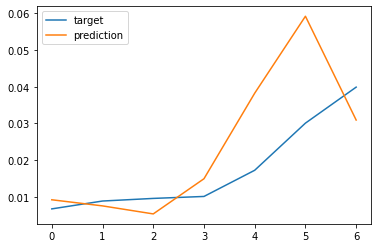

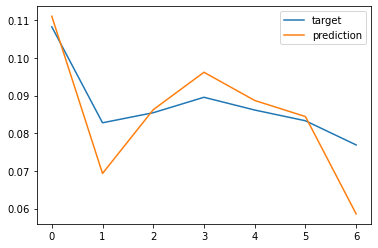

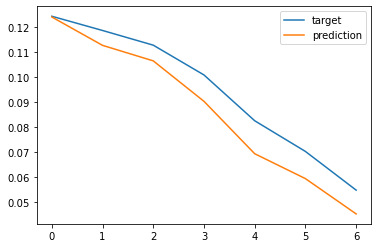

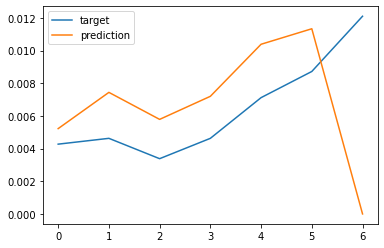

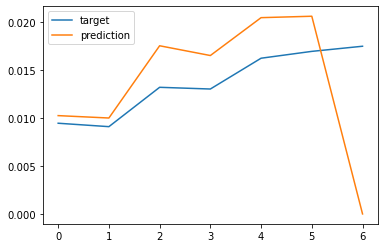

In [65]:
for i in range(1, 500, 100):

    plt.plot(training_set[i, :, 1], label="target")
    with torch.no_grad():
        predict_perc = torch.from_numpy(training_set[i:i+1, -1, 2]).type(torch.FloatTensor)
        pred = model(train_input[i:i+1], predict_perc).squeeze(0)
    plt.plot(pred, label="prediction")
    plt.legend()
    plt.show()

# The test

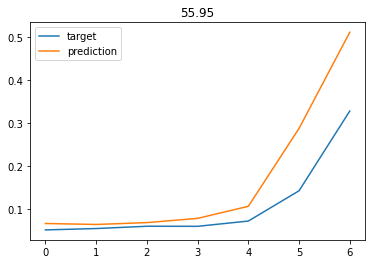

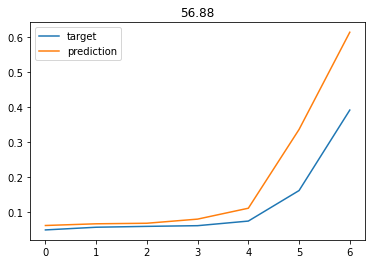

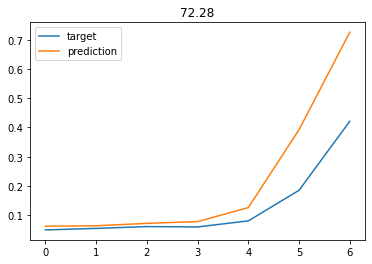

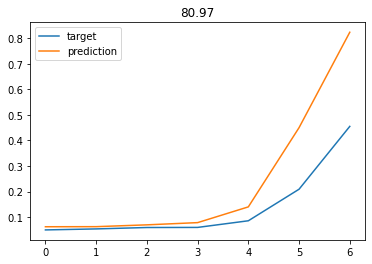

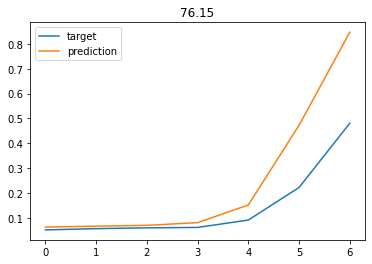

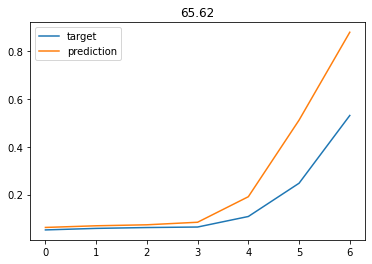

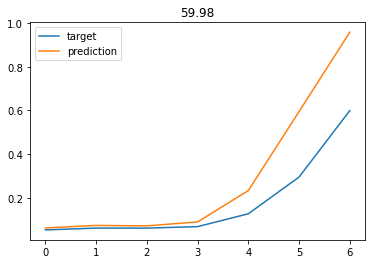

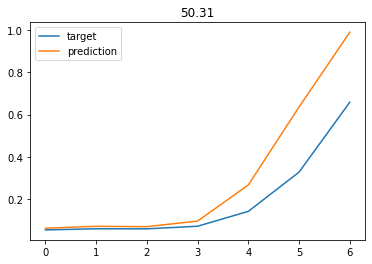

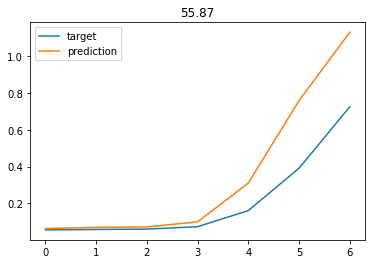

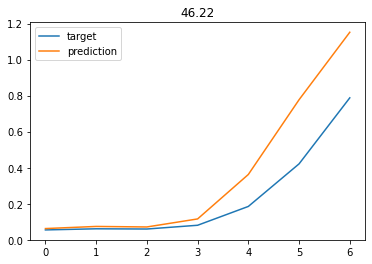

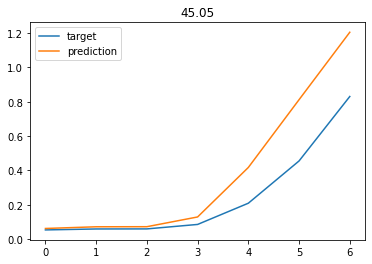

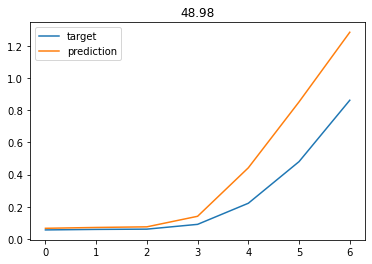

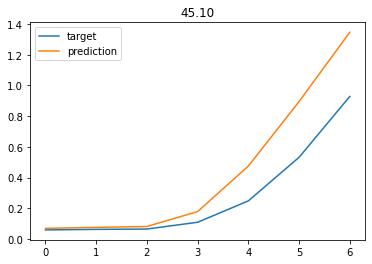

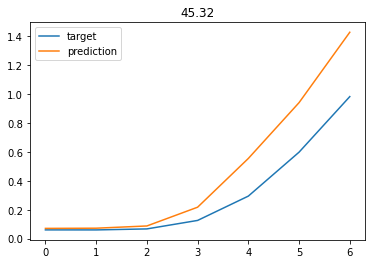

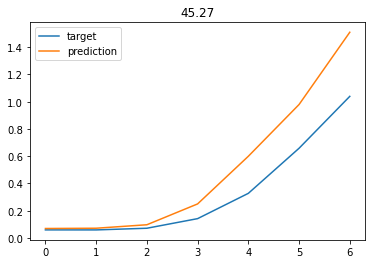

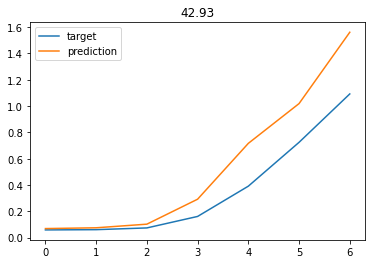

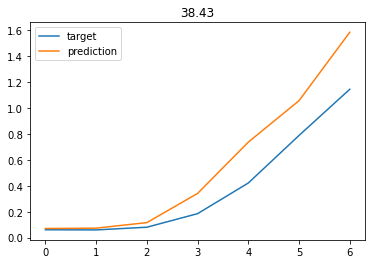

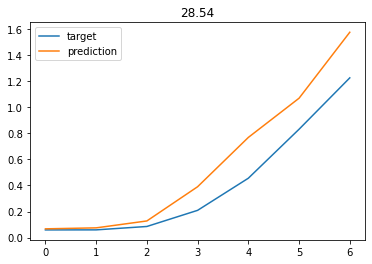

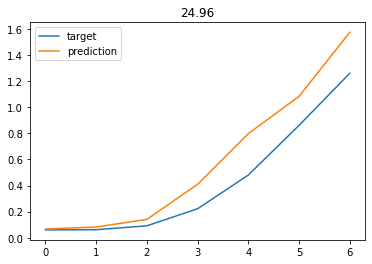

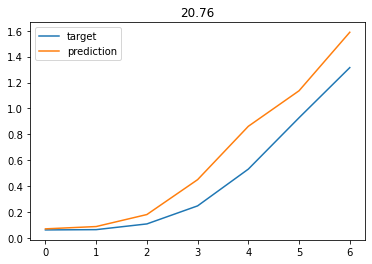

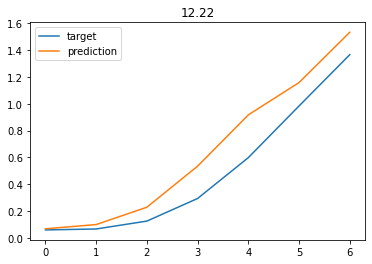

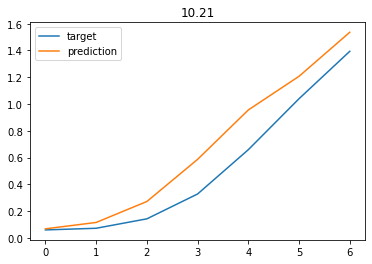

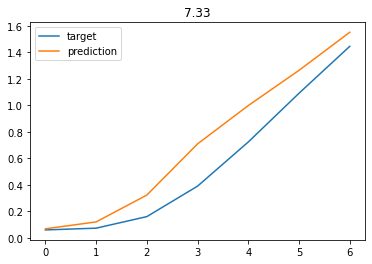

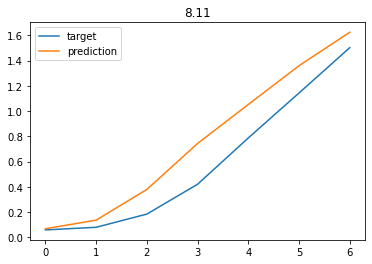

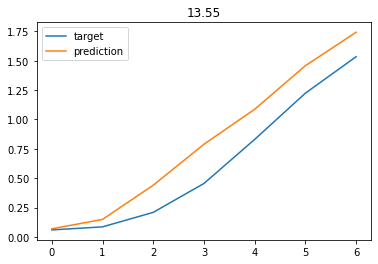

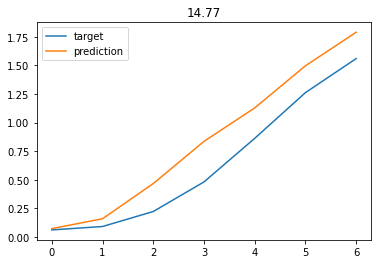

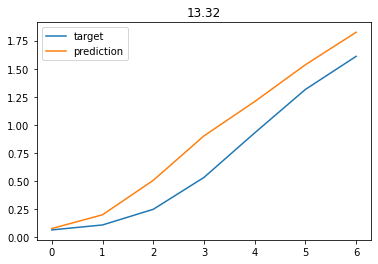

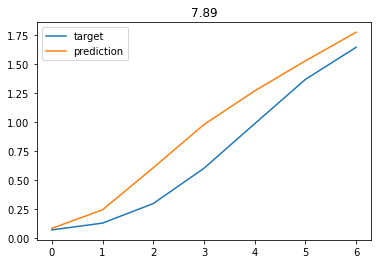

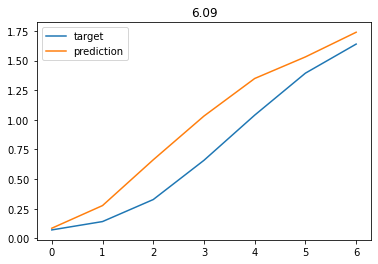

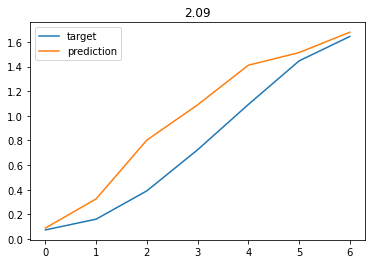

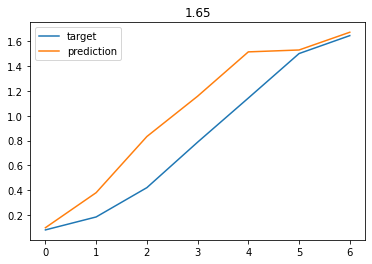

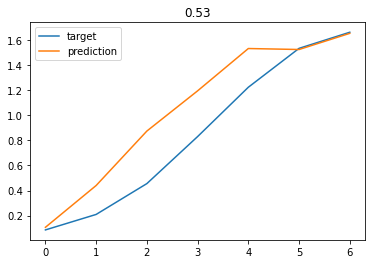

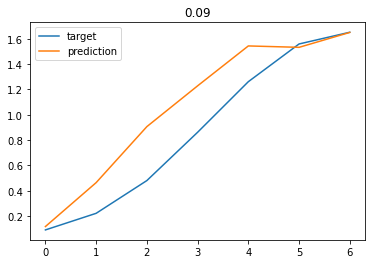

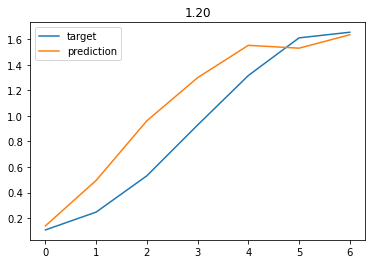

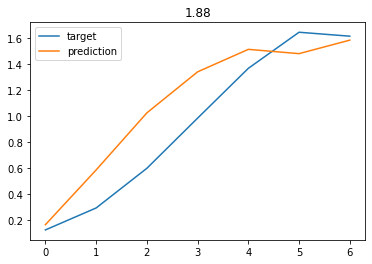

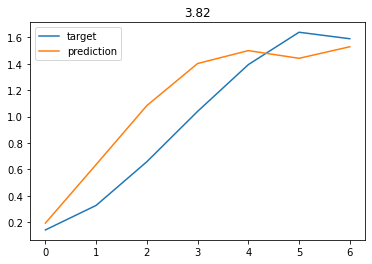

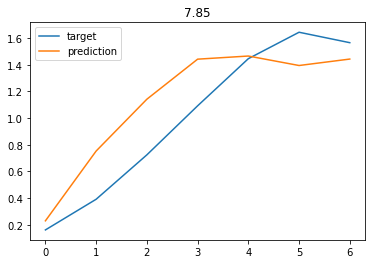

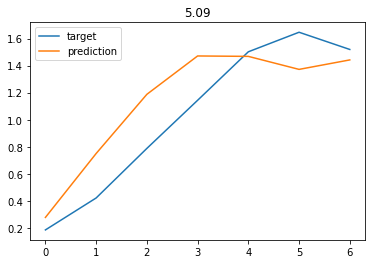

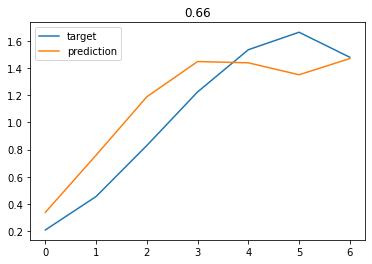

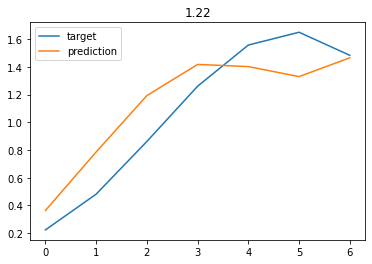

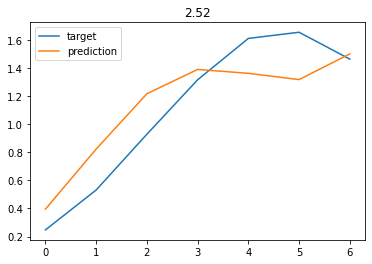

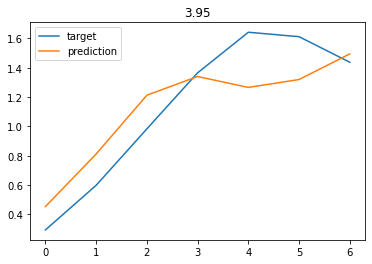

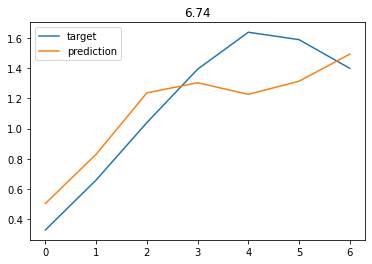

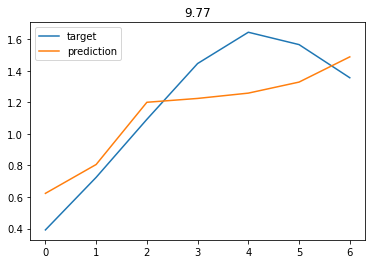

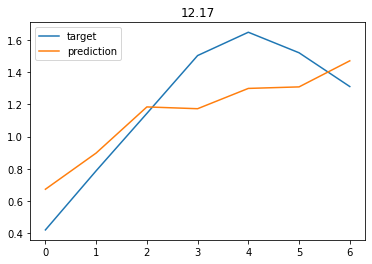

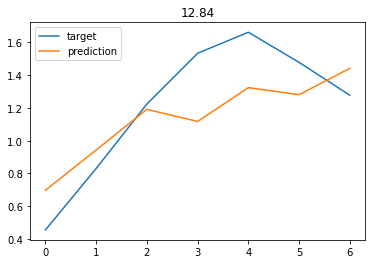

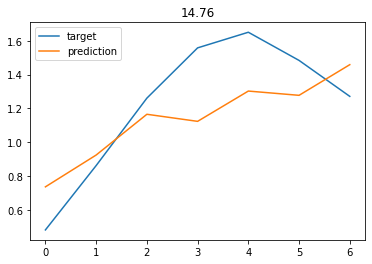

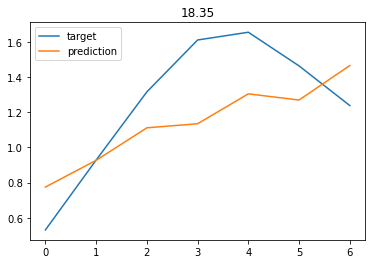

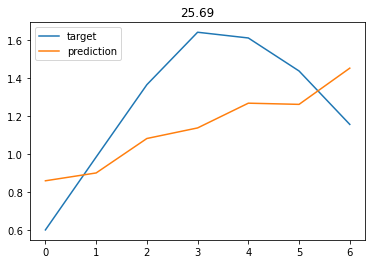

In [69]:
for i in range(1, 50, 1):

    plt.plot(test_set[i, :, 1], label="target")
    with torch.no_grad():
        predict_perc = torch.from_numpy(test_set[i:i+1, -1, 2]).type(torch.FloatTensor)
        pred = model(test_input[i:i+1], predict_perc).squeeze(0)
    plt.plot(pred, label="prediction")
    plt.title(f"{ np.abs(pred[-1].item()-test_set[i, -1, 1]) / test_set[i, -1, 1] * 100:.2f}")
    plt.legend()
    plt.show()